# BioSound Tutorial 3.  Reading a series of BioSound h5 files and calculating some summary statistics
### This notebook illustrates how to read BioSound objects that have been saved in h5 files and perform grouped averages and simple statistics

## Step 1. Loading all the dependencies.  
### numpy, matplotlib and soundsig should have been installed when you installed soundsig.  You might have to also install pandas.

In [1]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.sound import BioSound 

import os


## Step 2. Specifying the location of the sound files in BioSound format (h5 files).

YOU WILL WANT TO CHANGE TO FOLLOWING CODE TO POINT TO THE RIGHT PLACE
You will also want to change the location for storing the pandas table.

In [2]:
# Go to the folder that has the h5 files corresponding to the BioSound objects.
os.chdir('/Users/frederictheunissen/Code/BioSoundTutorial/BirdCalls/h5files')

tableStore = '/Users/frederictheunissen/Code/BioSoundTutorial/vocSelTable.h5'

## Step 3. Looping through a set of bioSoundObjects to extract some features and storing them into a Pandas Data Frame.

In [3]:
# vocSelData is going to be a list of dictionary containing the values that we are going to extract from each BioSound object.
vocSelData = []

# Looping through all the files
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        
        print(fname)
        # Allocate object and read data
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        
        # Take the time average formants 
        meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
        meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
        meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        
        # These are our two identifier - the emitter (bird) and the call type
        Bird = np.array2string(myBioSound.emitter)[2:-1]
        callType = np.array2string(myBioSound.type)[2:-1]

        # Get values for the fundamental
        if myBioSound.fund is not None:
            fund = float(myBioSound.fund)
            cvfund = float(myBioSound.cvfund)
            maxfund = float(myBioSound.maxfund)
            minfund = float(myBioSound.minfund)
        else:
            fund = float('NaN')
            cvfund = float('NaN')
            maxfund = float('NaN')
            minfund = float('NaN')
            
            
            

        vocSelData.append({"Bird": Bird, 
                     "calltype": callType, "fund": fund, 
                     "cvfund": cvfund, "maxfund": maxfund, "minfund": minfund,
                     "F1": meanF1, "F2": meanF2, "F3":meanF3,
                     "sal": float(myBioSound.meansal), "rms": float(myBioSound.rms), 
                     "maxAmp": float(myBioSound.maxAmp),
                     "meanS": float(myBioSound.meanspect), "stdS": float(myBioSound.stdspect),
                     "skewS": float(myBioSound.skewspect), "kurtS": float(myBioSound.kurtosisspect), 
                     "entS": float(myBioSound.entropyspect),
                     "q1": float(myBioSound.q1), "q2": float(myBioSound.q2), "q3": float(myBioSound.q3),                  
                     "meanT": float(myBioSound.meantime), "stdT": float(myBioSound.stdtime),
                     "skewT": float(myBioSound.skewtime), "kurtT": float(myBioSound.kurtosistime),
                     "entT": float(myBioSound.entropytime)
})

# Make a panda data frame with all the data                    
vocSelTable = pd.DataFrame(vocSelData)
vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')   


WhiRas44dd_110620-DC-03.h5
YelGre5275_110615-DC-10.h5
YelOra2575_110630-DC-48.h5
WhiRas44dd_110620-DC-13.h5
YelGre5275_110728-DC-20.h5
WhiLbl0010_110421-DC-06.h5
WhiRas44dd_110620-DC-07.h5
YelOra2575_110630-DC-39.h5
YelGre5275_110728-DC-24.h5
WhiRas44dd_110620-DC-17.h5
WhiLbl0010_110425-DC-14.h5
WhiRas44dd_110620-DC-23.h5
YelGre5275_110615-DC-04.h5
WhiLbl0010_110421-DC-07.h5
WhiRas44dd_110620-DC-06.h5
YelOra2575_110630-DC-38.h5
YelOra2575_110630-DC-28.h5
WhiRas44dd_110620-DC-16.h5
YelGre5275_110728-DC-25.h5
WhiLbl0010_110411-DC-01.h5
WhiRas44dd_110620-DC-22.h5
YelGre5275_110615-DC-05.h5
YelGre5275_110615-DC-11.h5
YelOra2575_110630-DC-49.h5
YelGre5275_110615-DC-01.h5
YelGre5275_110728-DC-21.h5
WhiRas44dd_110620-DC-12.h5
YelGre5275_110616-DC-17.h5
YelOra2575_110630-DC-37.h5
WhiLbl0010_110502-DC-24.h5
WhiRas44dd_110620-DC-09.h5
WhiLbl0010_110421-DC-08.h5
WhiRas44dd_110620-DC-19.h5
YelOra2575_110630-DC-42.h5
WhiLbl0010_110502-DC-20.h5
YelGre5275_110616-DC-13.h5
YelOra2575_110630-DC-33.h5
W

## Step 4. Calculate some summary statistics

In [4]:
vocSelTableGrouped = vocSelTable.groupby(['Bird'])
vocSelTableGroupedAgg = vocSelTableGrouped.aggregate('mean', numeric_only=True).reset_index()

vocSelTableGroupedAgg


,Bird,fund,cvfund,maxfund,minfund,F1,F2,F3,sal,rms,...,kurtS,entS,q1,q2,q3,meanT,stdT,skewT,kurtT,entT
0,WhiLbl0010,703.697903,0.121974,928.937243,471.907875,2580.139090,3902.673588,5036.066070,0.796746,3827.774084,...,9.123082,0.669783,3379.687500,3988.769531,4511.718750,0.111202,0.055454,-0.009022,1.831126,0.988922
1,WhiRas44dd,522.670125,0.250433,779.448411,305.404286,1895.405253,3755.295199,5067.497430,0.636869,1562.756153,...,4.913039,0.751195,3064.605469,3602.074219,4227.398438,0.127016,0.062014,-0.015648,2.057778,0.988704
2,YelGre5275,727.300084,0.130442,961.841635,572.789612,2074.846114,3616.343583,5092.943791,0.838358,1234.810546,...,7.464726,0.653951,2916.457031,3424.640625,3984.503906,0.104623,0.048260,-0.192828,2.243027,0.985460
3,YelOra2575,670.981774,0.092179,869.936151,502.634315,2099.741228,3643.695676,5154.407734,0.857714,1412.994508,...,6.631035,0.564774,3423.779297,3563.745117,4136.528320,0.114140,0.051947,0.013622,2.067124,0.979853


## Step 5. You can perform classical hypothesis testing at this point.  

For example, is the fundamental different for the four birds?  That is simple a one-way-anova.  I like to use
the statistical modeling approach with R like syntax.  Here 'lm' is the same as ordinary least square or 'ols'



In [5]:
# One way anova

import statsmodels.api as sm
from statsmodels.formula.api import ols
 
mod = ols('fund ~ Bird',
                data=vocSelTable).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                 sum_sq    df           F        PR(>F)
Bird      623096.084152   3.0  184.027536  1.485127e-37
Residual   98190.666848  87.0         NaN           NaN


The mean fundamental is clearly different for these four birds and you also see this in a boxplot

<Axes: title={'center': 'fund'}, xlabel='Bird'>

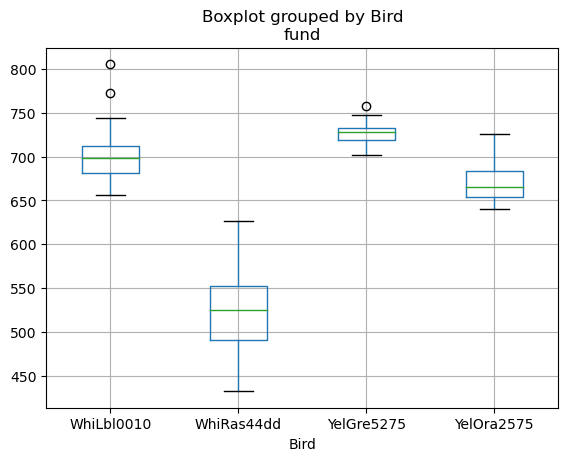

In [6]:
vocSelTable.boxplot('fund', by='Bird')